## Import libraries

In [2]:
import os, sys
#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import numpy as np
import imageio
from PIL import Image as im
import pprint
import matplotlib.pyplot as plt
%matplotlib inline
import run_nerf
import run_nerf_helpers
from pyntcloud.io import read_ply
import open3d as o3d
import open3d as open3d
import pandas as pd
from typing import Tuple, Optional



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Load trained network weights
Run bash download_example_weights.sh in the root directory if you need to download the Lego example weights



In [4]:

basedir = './logs'
expname = 'lego_example'

config = os.path.join(basedir, expname, 'config.txt')
print('Args:')
print(open(config, 'r').read())

parser = run_nerf.config_parser() 
ft_str = '--ft_path {}'.format(os.path.join(basedir, expname, 'model_200000.npy'))
args = parser.parse_args('--config {} '.format(config) + ft_str)

# Create nerf model
_, render_kwargs_test, start, grad_vars, models = run_nerf.create_nerf(args)

bds_dict = {
    'near' : tf.cast(2., tf.float32),
    'far' : tf.cast(6., tf.float32),
}
render_kwargs_test.update(bds_dict)

print('Render kwargs:')
pprint.pprint(render_kwargs_test)

net_fn = render_kwargs_test['network_query_fn']
print(net_fn)


Args:
expname = lego_example
basedir = ./logs
datadir = ./data/nerf_synthetic/lego
dataset_type = blender

half_res = True
no_batching = True

N_samples = 64
N_importance = 64

use_viewdirs = True

white_bkgd = True

N_rand = 1024

MODEL 63 27 <class 'int'> <class 'int'> True
(None, 90) (None, 63) (None, 27)
MODEL 63 27 <class 'int'> <class 'int'> True
(None, 90) (None, 63) (None, 27)
Not ndc!
Found ckpts ['./logs\\lego_example\\model_200000.npy']
Reloading from ./logs\lego_example\model_200000.npy
Resetting step to 200001
Reloading fine from ./logs\lego_example\model_fine_200000.npy
Render kwargs:
{'N_importance': 64,
 'N_samples': 64,
 'far': <tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
 'lindisp': False,
 'ndc': False,
 'near': <tf.Tensor: shape=(), dtype=float32, numpy=2.0>,
 'network_fine': <keras.engine.functional.Functional object at 0x000001DA0A5FFFA0>,
 'network_fn': <keras.engine.functional.Functional object at 0x000001DA0A5C2A10>,
 'network_query_fn': <function create_ne

## Query network 


Surfel points shape: (100000, 3)
Points shape: (100000, 3)
View directions shape: (100000, 3)
Generating surfel cloud with 100000 surfels
Raw shape: (100000, 4)
Surfels shape: (100000, 3)
Clean surfels shape: (5358, 3)
After cleaning, surfel cloud has 5358 surfels


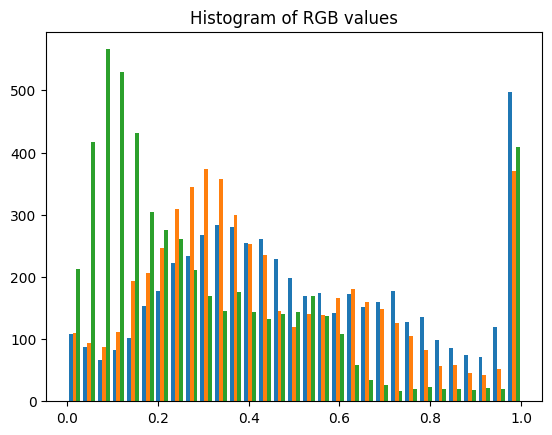

In [5]:
def generate_surfels(
    #num_surfels: int = 256, #for grid
    num_surfels: int = 100000, #for others
    bounding_box_min: Tuple[float, float, float] = (-1.2, -1.2, -1.2),
    bounding_box_max: Tuple[float, float, float] = (1.2, 1.2, 1.2),
    estimate_normals: bool = True,
    sigma_threshold = 5,
) -> o3d.geometry.PointCloud:
    
    '''Method 1'''
    #Generate uniform x, y, z coordinates - uniform distribution
    x_points = np.random.uniform(bounding_box_min[0], bounding_box_max[0], num_surfels)
    y_points = np.random.uniform(bounding_box_min[1], bounding_box_max[1], num_surfels)
    z_points = np.random.uniform(bounding_box_min[2], bounding_box_max[2], num_surfels)
    
    '''Method 2'''
#     #Generate x, y, z coordinates - gaussian distribution 
#     x_points = np.random.normal(bounding_box_min[0], bounding_box_max[0], num_surfels)
#     y_points = np.random.normal(bounding_box_min[1], bounding_box_max[1], num_surfels)
#     z_points = np.random.normal(bounding_box_min[2], bounding_box_max[2], num_surfels)
    
    # Combine the coordinates into surfels
    
       #for grid
#     surfel_pts = np.stack(np.meshgrid(x_points, y_points, z_points), -1).astype(np.float32)

      #for others
    surfel_pts = np.stack((x_points, y_points, z_points), axis=1).astype(np.float32)
    
    print(f"Surfel points shape: {surfel_pts.shape}")
    sh = surfel_pts.shape
    points = surfel_pts.reshape([-1,3])
    print(f"Points shape: {points.shape}")
    
    '''You can try with different viewing directions to change color '''
    
    # View directions will change the color of surfels
    #viewdirs = np.zeros_like(points) #better
    #viewdirs = np.ones_like(points) #worse
    viewdirs = np.array([np.array([0.5, 0.5, 0.5])] * points.shape[0]).astype(np.float32) #better
    #viewdirs = np.array([np.array([-0.5, -0.5, -0.5])] * points.shape[0]).astype(np.float32) #normal
    print(f"View directions shape: {viewdirs.shape}")

    def batchify(fn, chunk):
        if chunk is None:
            return fn
        def ret(inputs):
            return tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
        return ret
    
    print(f"Generating surfel cloud with {len(points)} surfels")
    fn = lambda i0, i1 : net_fn(points[i0:i1,None,:], viewdirs=viewdirs[i0:i1,:], network_fn=render_kwargs_test['network_fine'])
    chunk = 1024*64
    raw = np.concatenate([fn(i, i+chunk).numpy() for i in range(0, points.shape[0], chunk)], 0)
    raw = np.reshape(raw, list(sh[:-1]) + [-1])
    sigma = np.maximum(raw[...,-1], 0.)
    
    # Surface colors 
    rgb = raw[...,:3]
    rgbs = np.reshape(rgb, list(points.shape[:-1]) + [-1])
    
    # Surface normals 
    normal = raw[...,:3]
    normals = np.reshape(normal, list(points.shape[:-1]) + [-1])

    # Sigma 
    sigmas = np.reshape(sigma, list(points.shape[:-1]) + [-1])
    print(f"Raw shape: {raw.shape}")
    print(f"Surfels shape: {points.shape}")
    
    '''Remove noise''' 
    
    # Clean the surfel cloud of surfels with low opacity
    opacity_mask = (sigmas[:, 0] > sigma_threshold)
    clean_points = points[opacity_mask, :]
    clean_rgb = rgbs[opacity_mask, :]
    clean_normals = normals[opacity_mask, :]
    
    print(f"Clean surfels shape: {clean_points.shape}")
    print(f"After cleaning, surfel cloud has {len(clean_points)} surfels")
    
    '''Normalization layer'''

    # Normalize the points to be between 0 and 1
    clean_points = 1/(1 + np.exp(-clean_points))
    clean_points = clean_points.astype(np.float64)
    
    # Normalize the RGB values to be between 0 and 1
    clean_rgb = 1/(1 + np.exp(-clean_rgb))
    clean_rgb = clean_rgb.astype(np.float64)
    
    # Normalize the normal values to be between 0 and 1
    clean_normals = 1/(1 + np.exp(-clean_normals))
    clean_normals = clean_normals.astype(np.float64)


    # histogram
    _ = plt.hist(clean_rgb, bins='auto')  
    plt.title("Histogram of RGB values")
    plt.show()

    surfels = o3d.geometry.PointCloud()
    surfels.points = o3d.utility.Vector3dVector(clean_points)
    surfels.colors = o3d.utility.Vector3dVector(clean_rgb)
    surfels.normals = o3d.utility.Vector3dVector(clean_normals)
    return surfels

surfels = generate_surfels()


## Save surfel cloud as .ply file

In [6]:
o3d.io.write_point_cloud("logs/lego_test/lego_surfels.ply", surfels)
print(f"File saved as lego_surfels.ply")

File saved as lego_surfels.ply


## Visualize surfel cloud
#### press N to visualize surface normals and esc to quit

In [7]:
surfels = o3d.io.read_point_cloud("logs/lego_test/lego_surfels.ply")
o3d.visualization.draw_geometries([surfels])

## Farthest point sampling

In [20]:
surfels = o3d.io.read_point_cloud("logs/lego_test/lego_surfels.ply")

#Select desired number of points
surfels_sampled  = surfels.farthest_point_down_sample(1000)
o3d.visualization.draw_geometries([surfels_sampled])
#print(surfels_sampled)

## Color mesh
##### Surface reconstruction - Alpha Shapes

In [23]:
import open3d as o3d

# You can try with different alpha values
alpha =0.02
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(surfels, alpha)
#mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)
print(f"Generated {mesh}")
o3d.io.write_triangle_mesh("logs/lego_test/lego_mesh.ply", mesh)
print(f"File saved as lego_mesh.ply")

Generated TriangleMesh with 2989 points and 6192 triangles.
File saved as lego_mesh.ply
